# Normal Linear Regression Model
Consider a simple model with only one regressor
$$y=x\beta+\epsilon,\quad i=1,\dots,n$$
ASSUMPTIONS:
1. Gaussian iid errors $\epsilon\sim N(0,\sigma^2)$
2. $x_i$ and $\epsilon_j$ are independent $\forall i\neq j$

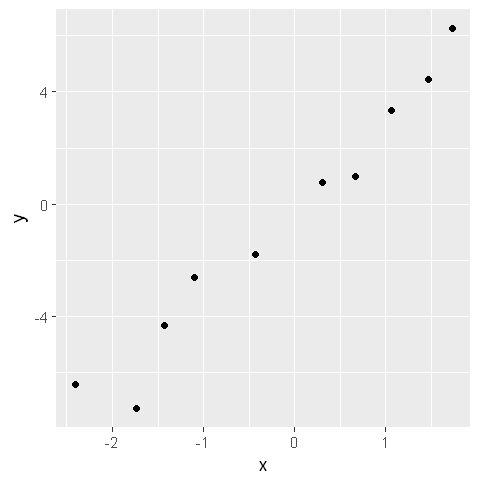

In [2]:
# Generate the sample
library(ggplot2)
library(repr)

options(repr.plot.width=4, repr.plot.height=4)
n = 10
beta = 3
x = rnorm(n)
e = rnorm(n)
y = beta*x+e
data = data.frame(x,y,size=1)
qplot(x,y)

## Choosing the Prior
Selecting the prior $\beta|\sigma^2\sim N(\beta_0,\sigma^2V_0)$ and $\sigma^2\sim IG(1/\sigma^2_0,\nu_0)$
$$f(x|\alpha,\beta)=$$
Recall that if $X\sim G(\theta_1,\theta_2)$ then $1/X\sim IG(\theta_1,\theta_2)$, hence
$$\sigma^{-2}\sim G(\sigma^{-2}_0,\nu_0)$$
where $\mathbb{E}(\sigma^{-2})= \sigma^{-2}_0$ and $\mathbb{V}(\sigma^{-2})=\frac{2}{\sigma^4_0\nu}$

In [3]:
# Selecting the Prior
m = 1
prior = list(b0 = 2.5,V0 = 1/m*0.05, nu0 =m*1, sigma2_0 = 1)
prior

$b0
[1] 2.5

$V0
[1] 0.05

$nu0
[1] 1

$sigma2_0
[1] 1

## Calculating the Posterior

In [4]:
# Function for the Posterior of the NLRM
NLRM = function(data,prior) {
  XX = t(data$x)%*%data$x
  b_hat = solve(XX, t(data$x%*%data$y))
  k = dim(data)[2]-1
  n = dim(data)[1]
  s2 = sum((data$y-data$x%*%b_hat)^2)/(n-k)
  V = solve(solve(prior$V0) + XX)
  b = V%*%(solve(prior$V0)%*%prior$b0+XX%*%b_hat)
  nu = prior$nu0+n
  sigma2 = (prior$nu0*prior$sigma2_0+(n-k)*s2+t(b_hat-prior$b0)%*%solve(prior$V0+solve(XX))%*%(b_hat-prior$b0))/nu
  return(list(beta = b, V = V, nu = nu, sigma2 = sigma2, s2 = s2, b_hat = b_hat))
}

# Calculating the posterior
P = NLRM(data,prior)

## Plotting the Results for the Posterior Marginals

In [ ]:
# Generalized t-Distribution
tdist = function(x, mu=0,S=1,k=1) {
  p = length(mu)
  c = gamma((k+p)/2)/(gamma(k/2)*(k*pi)^(p/2)*sqrt(det(as.matrix(S))))
  ftdist = function(x) c*(1+1/k*t(x-mu)%*%solve(S)%*%(x-mu))^(-(k+p)/2)
  return(apply(as.matrix(x),1,ftdist))
}

# Reparamertized Inverted Gamma    
igdist = function(x, mu = 1, v = 1) {
  c = ((v/(2*mu))^(v/2))/gamma(v/2)
  figdist = function(x) c*x^(-v/2-1)*exp(-v/(2*mu*x))
  return(apply(as.matrix(x),1,figdist))
}

# Multiplot function
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

var_beta = P$nu/(P$nu-2)*P$sigma2*P$V
n_dp = 5
x_beta = seq(-n_dp*sqrt(var_beta)+P$beta,P$beta+n_dp*sqrt(var_beta),length.out=100)
x_sigma = seq(0.01,4,length.out=100)
prior_sigma = igdist(x_sigma,1/prior$sigma2_0,prior$nu0)
prior_beta = tdist(x_beta,prior$b0,prior$sigma2_0*prior$V0,prior$nu0)
posterior_beta = tdist(x_beta,P$beta,P$sigma2*P$V,P$nu)
posterior_sigma = igdist(x_sigma,1/P$sigma2,P$nu)
plotdata = data.frame(x_beta,x_sigma,prior_beta,prior_sigma,posterior_beta,posterior_sigma)

p1 = ggplot(plotdata, aes(x_beta)) + 
  geom_line(aes(y = prior_beta, colour = "Prior")) + 
  geom_line(aes(y = posterior_beta, colour = "Posterior")) +
  geom_vline(xintercept=P$b_hat) +
  ggtitle("t-Distribution") +
  xlab(expression(beta)) +
  theme(legend.position = c(0.85, 0.95),
        legend.title=element_blank(),
        axis.title.y=element_blank(),
        plot.title = element_text(hjust = 0.5),
        aspect.ratio=1
       ) 

p2 = ggplot(plotdata, aes(x_sigma)) + 
  geom_line(aes(y = prior_sigma, colour = "Prior")) + 
  geom_line(aes(y = posterior_sigma, colour = "Posterior")) +
  geom_vline(xintercept=P$s2) +
  ggtitle("Inverted Gamma Distribution") +
  xlab(expression(sigma^{2})) +
  theme(legend.position='none',
        axis.title.y=element_blank(),
        plot.title = element_text(hjust = 0.5),
        aspect.ratio=1
       )  

options(repr.plot.width=8, repr.plot.height=8)    
multiplot(p1, p2, cols=2)

## Model Selection
Let's consider the following the following NLRM
$$y=\beta_1 x_1+ \beta_2 x_2+\epsilon,\quad i=1,\dots,n$$
But $\mathcal{M}_0:\beta_1=0$

In [ ]:
options(repr.plot.width=4, repr.plot.height=4)
n = 10
beta1 = 0
beta2 = -1
x1 = rnorm(n)
x2 = rnorm(n)
e = rnorm(n)
y = beta1*x1+beta2*x2+e
data = data.frame(x,y,size=1)
qplot(x,y)